## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the Dataset

In [2]:
import os
import tarfile

### Process and visualize the dataset

Then we load the citations data into a Pandas DataFrame.

In [3]:
def transform_pubmed(inFeat, outFeat, inNet, outNet):
    with open(inFeat) as f:
        with open(outFeat, 'w') as out:
            ignore = True
            head = True
            target = {}
            features = {}
            for line in f:
                if ignore:
                    ignore = False
                    continue
                if head:
                    head = False
                    s = line.split()[1:-1]
                    s = [x.split(':')[1] for x in s]
                    feats_nums = {s[i]: i for i in range(len(s))}
                    continue
                s = line.split()
                id = s[0]
                target[id] = s[1].split('=')[1]
                assert (s[1].split('=')[0] == 'label')
                idx = [feats_nums[x.split('=')[0]] for x in s[2:-1]]
                feats = [1 if i in idx else 0 for i in range(len(feats_nums))]
                features[id] = feats
                out.write(id + ' ')
                out.write(' '.join([str(x) for x in feats]))
                out.write(' ' + target[id] + '\n')
    with open(inNet) as f:
        with open(outNet, 'w') as out:
            ignore = True
            head = True
            for line in f:
                if ignore:
                    ignore = False
                    continue
                if head:
                    head = False
                    continue
                s = line.split()
                u = s[1].split(':')[1]
                v = s[3].split(':')[1]
                out.write(v + ' ' + u + '\n')
                


In [4]:
import os

# Dataset and paths
dataset_name = 'pubmed'
input_dir = '/kaggle/input/pumbed1'  # Read-only input directory in Kaggle
output_dir = '/kaggle/working/data/graphs/processed'  # Writable directory for processed data

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# File paths
node_file = os.path.join(input_dir, 'Pubmed-Diabetes.NODE.paper.tab')  # Input node file
content_file = os.path.join(output_dir, f'{dataset_name}.content')  # Output content file
cites_file = os.path.join(input_dir, 'Pubmed-Diabetes.DIRECTED.cites.tab')  # Input cites file
cites_output_file = os.path.join(output_dir, f'{dataset_name}.cites')  # Output cites file

# Call transform_pubmed with updated paths
transform_pubmed(node_file, content_file, cites_file, cites_output_file)
data_dir = f'/kaggle/working/data/graphs/processed'
print(f"Processed files saved in {output_dir}")


Processed files saved in /kaggle/working/data/graphs/processed


In [5]:
print(node_file)

# Class 0: Diabetes Type 1
# Class 1: Diabetes Type 2
# Class 2: Experimental research on diabetes (other diabetes-related studies)

/kaggle/input/pumbed1/Pubmed-Diabetes.NODE.paper.tab


In [6]:
citations = pd.read_csv(
    os.path.join(data_dir, "pubmed.cites"),
    sep=" ", 
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (44338, 2)


Now we display a sample of the `citations` DataFrame.
The `target` column includes the paper ids cited by the paper ids in the `source` column.

In [7]:
citations.sample(frac=1).head()

,target,source
25900,10386239,18235151
22133,15611284,18477810
13301,9224218,12836867
36392,9103469,10430939
37389,12730827,17693571


Now let's load the papers data into a Pandas DataFrame.

In [8]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(500)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "pubmed.content"), sep=" ", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (19717, 502)


In [9]:
print(papers["subject"])

0        1
1        1
2        1
3        2
4        1
        ..
19712    3
19713    2
19714    1
19715    3
19716    3
Name: subject, Length: 19717, dtype: int64


In [10]:
print(papers.head())

   paper_id  term_0  term_1  term_2  term_3  term_4  term_5  term_6  term_7  \
0  12187484       1       1       1       1       1       1       1       1   
1   2344352       1       0       1       0       0       0       0       0   
2  14654069       1       0       1       0       0       0       0       0   
3  16443886       0       0       0       0       0       0       0       0   
4   2684155       1       0       0       0       0       0       0       0   

   term_8  ...  term_491  term_492  term_493  term_494  term_495  term_496  \
0       1  ...         0         0         0         0         0         0   
1       1  ...         0         0         0         0         0         0   
2       1  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       1  ...         0         0         0         0         0         0   

   term_497  term_498  term_499  subject  
0         0  

Now we display a sample of the `papers` DataFrame. The DataFrame includes the `paper_id`
and the `subject` columns, as well as 1,433 binary column representing whether a term exists
in the paper or not.

In [11]:
print(papers.sample(5).T)

            13774     7205     1542     8008     10965
paper_id  2369660  16530579  9188514  8435991  7930374
term_0          0         0        0        0        0
term_1          0         0        0        0        0
term_2          0         0        1        0        1
term_3          0         0        0        0        0
...           ...       ...      ...      ...      ...
term_496        0         0        0        0        0
term_497        0         0        0        0        0
term_498        0         0        0        0        0
term_499        0         0        0        0        0
subject         2         2        3        3        2

[502 rows x 5 columns]


Let's display the count of the papers in each subject.

In [12]:
print(papers.subject.value_counts())

subject
2    7875
3    7739
1    4103
Name: count, dtype: int64


We convert the paper ids and the subjects into zero-based indices.

In [13]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

Now let's visualize the citation graph. Each node in the graph represents a paper,
and the color of the node corresponds to its subject. Note that we only show a sample of
the papers in the dataset.

# **VIS1**

/opt/conda/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


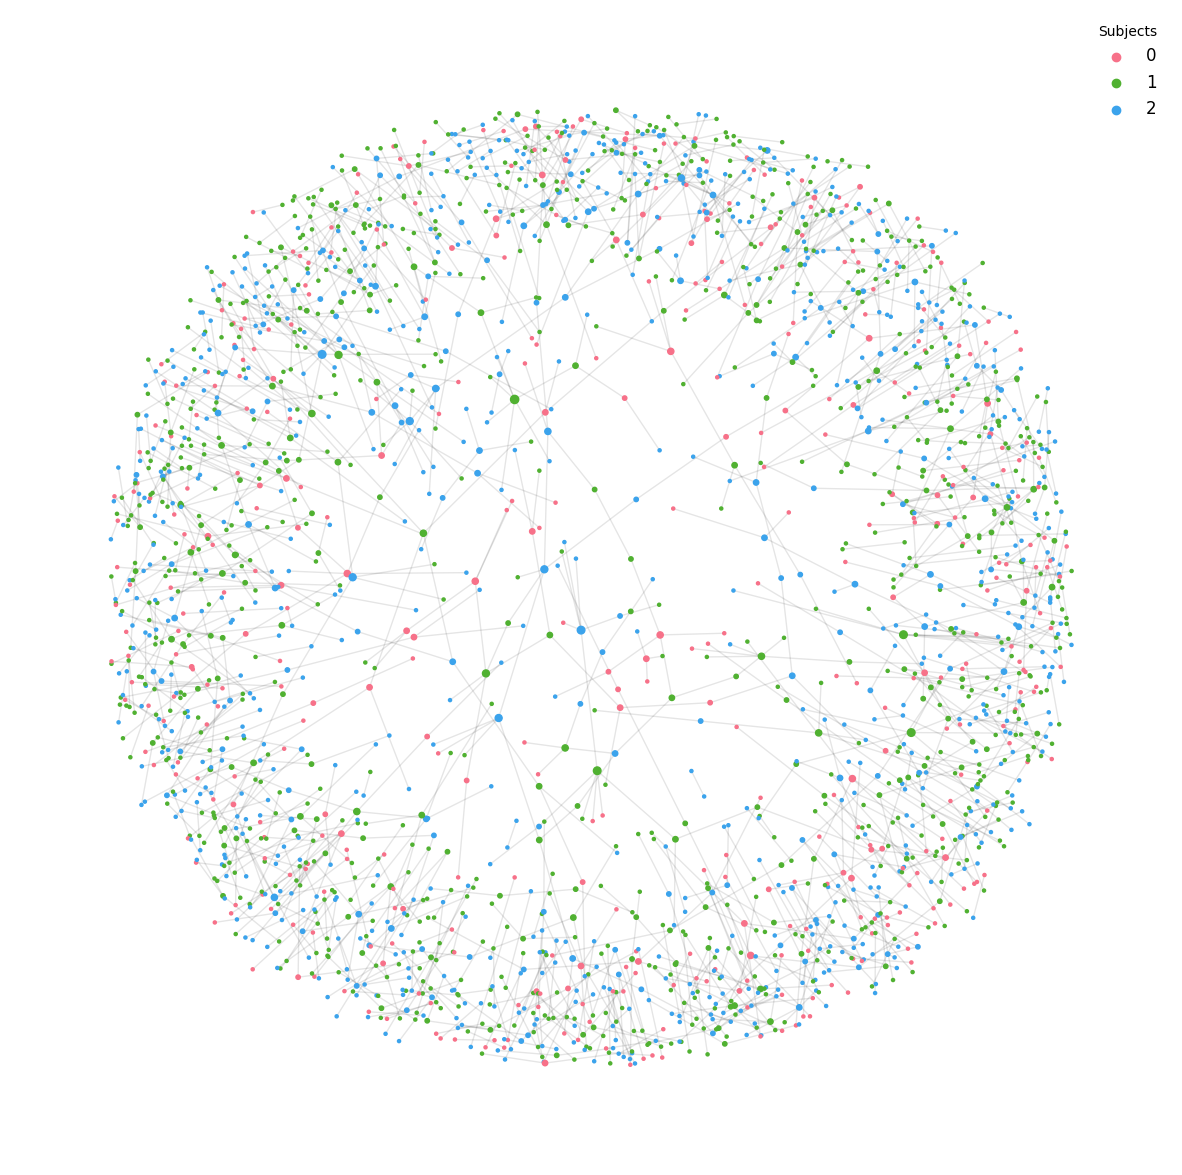

In [14]:

#A more visually appealing Graph #Megha
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# Increase the figure size to accommodate the larger graph
plt.figure(figsize=(15, 15))

# Create the graph from a sample of the citations
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))

# Get the subjects for the sampled nodes
subjects = papers[papers["paper_id"].isin(cora_graph.nodes())]["subject"]

# Create a color palette based on unique subjects
unique_subjects = list(papers["subject"].unique())
palette = sns.color_palette("husl", len(unique_subjects))  # Seaborn color palette
color_map = dict(zip(unique_subjects, palette))  # Map subjects to colors
node_colors = [color_map[subj] for subj in subjects]

# Calculate node degrees to scale node sizes (optional)
degrees = dict(nx.degree(cora_graph))
node_sizes = [degrees[node] * 5 for node in cora_graph.nodes()]  # Adjust size scale

# Plot the graph using a spring layout
pos = nx.spring_layout(cora_graph, k=0.1, iterations=50)  # k and iterations adjusted for larger graphs
nx.draw_networkx_edges(cora_graph, pos, alpha=0.1)  # Add transparency to edges
nx.draw_networkx_nodes(cora_graph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis)

# Add a legend for the subject categories
for subject, color in color_map.items():
    plt.scatter([], [], c=[color], label=subject)
plt.legend(scatterpoints=1, frameon=False, title="Subjects", loc="best", fontsize=12)

# Hide axis for a cleaner look
plt.axis('off')

plt.show()

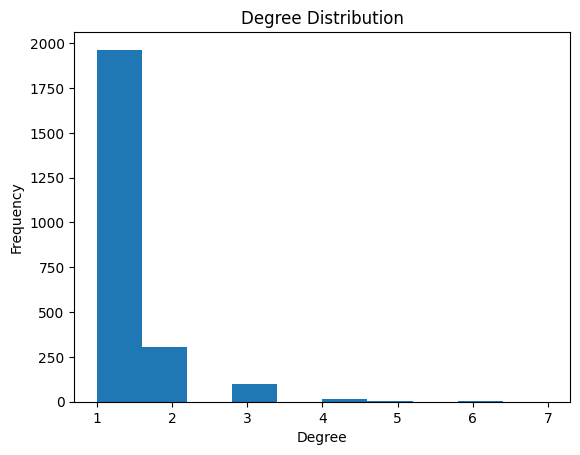

In [15]:
degrees = [cora_graph.degree(n) for n in cora_graph.nodes]
plt.hist(degrees, bins=10)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

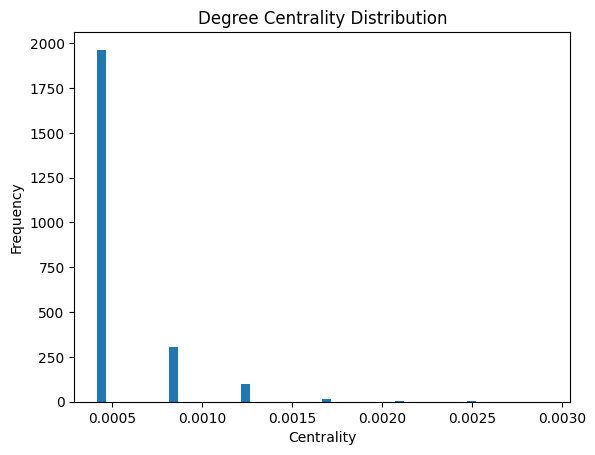

In [16]:
centrality = nx.degree_centrality(cora_graph)
centrality_values = list(centrality.values())

plt.hist(centrality_values, bins=50)
plt.title("Degree Centrality Distribution")
plt.xlabel("Centrality")
plt.ylabel("Frequency")
plt.show()


# **VIS2**

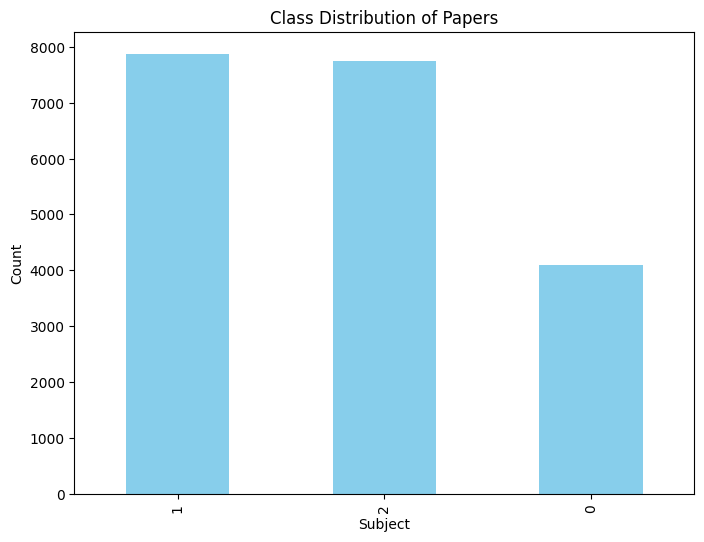

In [17]:
plt.figure(figsize=(8, 6))
papers['subject'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Class Distribution of Papers")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.show()

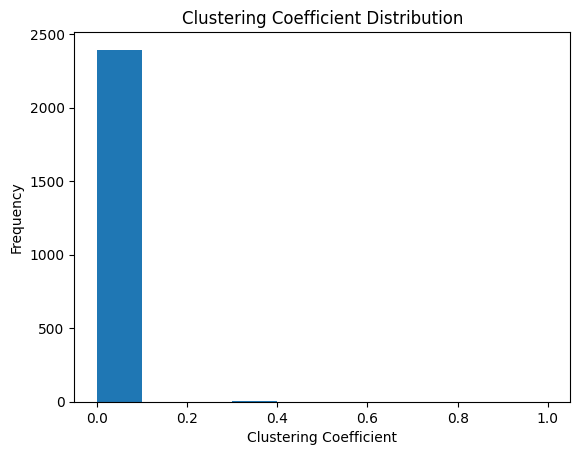

In [18]:
## Visualize the local clustering coefficient, which measures how close a node’s 
## neighbors are to forming a complete graph (i.e., how interconnected they are).

clustering_coeffs = nx.clustering(cora_graph)
plt.hist(clustering_coeffs.values(), bins=10)
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.show()


# **VIS3**

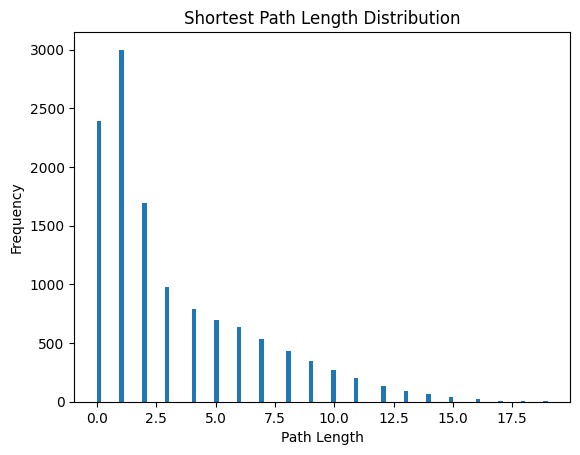

In [19]:
## Plot the distribution of the shortest path lengths between nodes, which can reveal how interconnected the graph is.
path_lengths = dict(nx.shortest_path_length(cora_graph))
all_lengths = [length for source in path_lengths for length in path_lengths[source].values()]

plt.hist(all_lengths, bins=100)
plt.title("Shortest Path Length Distribution")
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.show()

In [20]:
density = nx.density(cora_graph)
print(f"Graph Density: {density:.4f}")

Graph Density: 0.0005


# **VIS4**

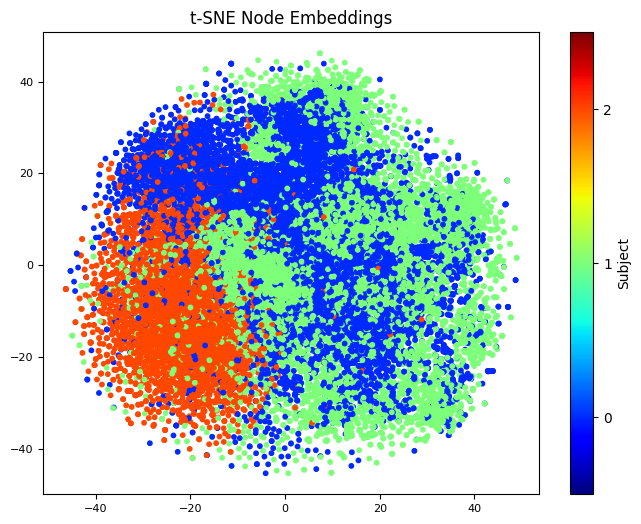

In [21]:
from sklearn.manifold import TSNE

# Assuming 'features' is the node feature matrix from the earlier processing
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(papers.iloc[:, 1:-1].values)

subject_mapping = {subject: idx for idx, subject in enumerate(class_values)}
papers['subject_numeric'] = papers['subject'].map(subject_mapping)
papers['subject_numeric'] = papers['subject_numeric'].fillna(2.0)

plt.figure(figsize=(8, 6))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=papers['subject_numeric'], cmap='jet', s=10)
plt.title("t-SNE Node Embeddings")
plt.colorbar(ticks=range(len(class_values)), label='Subject')
plt.clim(-0.5, len(class_values) - 0.5)  # Adjust color limits to match subject range
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

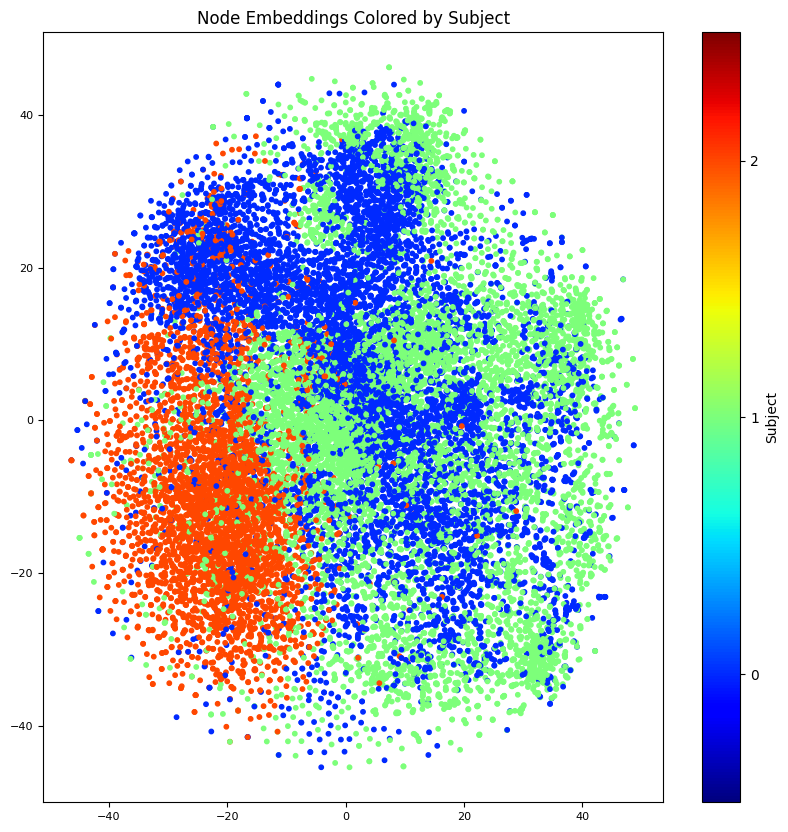

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=papers['subject_numeric'], cmap='jet', s=10)
plt.title("Node Embeddings Colored by Subject")
plt.colorbar(ticks=range(len(class_values)), label='Subject')
plt.clim(-0.5, len(class_values) - 0.5)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

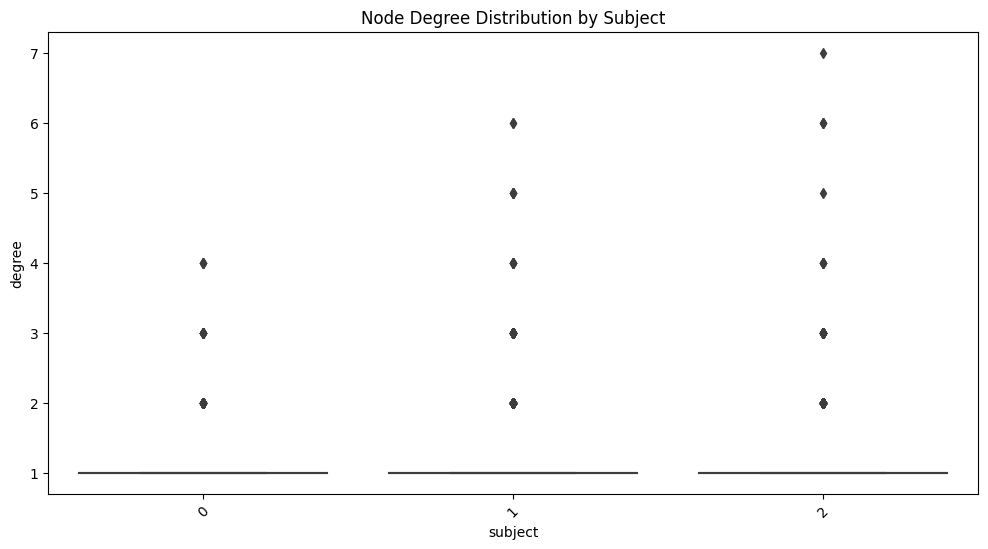

In [23]:
subject_degrees = pd.DataFrame({
    'degree': [cora_graph.degree(node) for node in cora_graph.nodes()],
    'subject': [
        papers.loc[papers['paper_id'] == node, 'subject'].values[0] if not papers.loc[papers['paper_id'] == node, 'subject'].empty else None
        for node in cora_graph.nodes()
    ]
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='subject', y='degree', data=subject_degrees)
plt.title("Node Degree Distribution by Subject")
plt.xticks(rotation=45)
plt.show()

# **VIS5**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

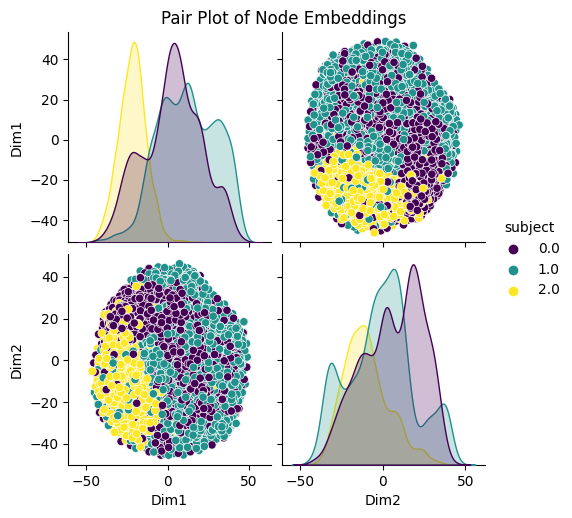

In [24]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for the embeddings
embedding_df = pd.DataFrame(node_embeddings_2d, columns=['Dim1', 'Dim2'])
embedding_df['subject'] = papers['subject'].map(subject_mapping)
embedding_df['subject'] = embedding_df['subject'].fillna(2.0)

sns.pairplot(embedding_df, hue='subject', palette='viridis')
plt.suptitle("Pair Plot of Node Embeddings", y=1.02)
plt.show()